# CAB420, Encoders and Decoders, Example: Auto-Encoders
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
Autoencoders are an unsupervised neural network. They take an input, learn a compressed representation of that input, and then try to reconstruct it. 

In that sense they function a little like PCA, but they can learn a highly non-linear representation. We can also "stack" them if we wish.

## Too Long; Didn't Read:
The main take home messages from this example are:
* Autoencoders learn a compact representation of the data, much like we can with PCA.
* The networks themselves have two main parts, an encoder, which takes the input and "shrinks" it; and a decoder, that takes this shrunken version and blows it back up again.
* The size of the end of our encoder determines how much compression we achieve.
* Auto-encoders are basically regression networks, with the input and target being the same thing. As a result of this, they don't need labels (like PCA). Also like PCA, the compressed represenation can be used for other things.
* Unlike PCA, the compressed representation is not really interpetable, we don't have new dimensions or anything, just a bunch of numbers.
* Auto-encoders do tend to adapt better to unseen data than PCA, so for very diverse data they can offer better performance.
* We can stack autoencoders to get further compression. Note however that this is not shown here.

In [1]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras import regularizers

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import model_to_dot, plot_model

import numpy

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### A Hyper-parameter

I'm defining this here to allow you to play with this and and tweak the size of the auto-encoder easily. This will define the size of our encoded (i.e. compressed) representations.

In [2]:
encoding_dim = 64

In [3]:
(x_train, _), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), numpy.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), numpy.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## A Simple (and crap) Auto-Encoder
Our network has three parts:
* The input
* The encoder
* The decoder
The input is pretty straight forward, it's our input layer. For our simple network it's just a flattened image, which we know to be not as good as using a Convolutional network and exploiting the spatial information in the data.

Note that I could build each of these as their own sub-networks and chain them together, similar to what was done in the metric learning examples.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488

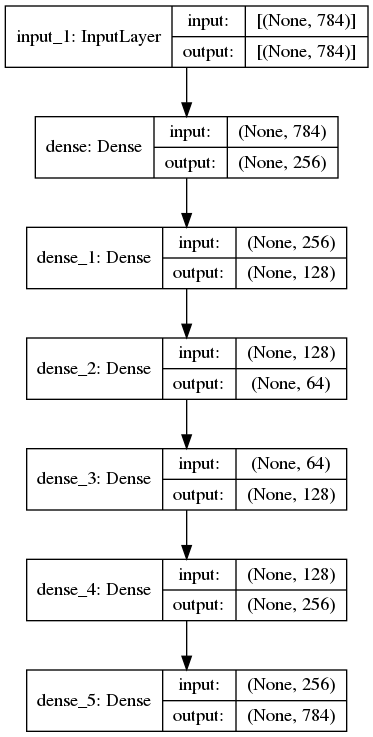

In [4]:
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim*4, activation='relu')(input_img)
encoded = Dense(encoding_dim*2, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(encoding_dim*2, activation='relu')(encoded)
decoded = Dense(encoding_dim*4, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
print(autoencoder.summary())
plot_model(autoencoder, show_shapes=True)

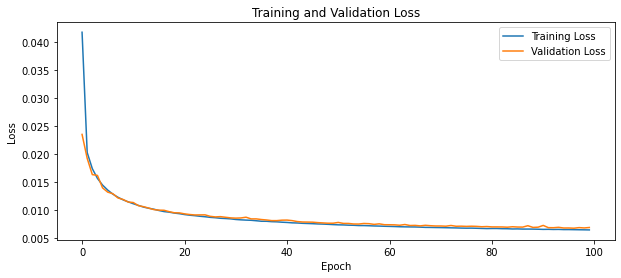

In [5]:
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test), verbose = False)

def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_history(history.history)

We see that our model trains, and it can reconstruct things to a fair extent. It's far from perfect, but it's not bad either. We see lots of detail being lost (consider the checked shirt), edges are fuzzy, etc; but the broad shape and tone is recovered.

This loss of detail is a product of two things:
* The size of our compressed representation
* The fact that we're using dense layers and ignoring the spatial information in the data

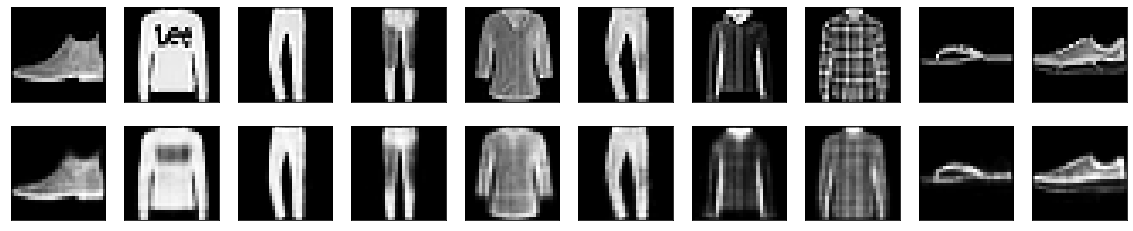

In [6]:
decoded_imgs = autoencoder.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## L1 Regularisation

Our aim with the autoencoder is to learn a compact representation of the input, not unlike what happens with PCA.

One issue we may have is that it's hard to know what our autoencoder is learning. Is it actually learning something meaninful that will generalise, or just some shallow knowledge? For example, is it learning something about the image and the object that is shown, or just how to resize an image?

One thing we can do to try and promote a more meaninful representation is to add a sparse penalty term. This will function in a manner somewhat similar to Lasso regression, and it will try to limit how many neurons are on at a time and lead to a sparse representation. The hope is that by learning a representation that allows reconstruction from very few non-zero elements, we're forcing the network to learn a more meaninful representation (and not just a resizing operation).

In [7]:
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim*4, activation='relu')(input_img)
encoded = Dense(encoding_dim*2, activation='relu')(encoded)

# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu', name='bottleneck',
                activity_regularizer=regularizers.l1(10e-5))(encoded)

decoded = Dense(encoding_dim*2, activation='relu')(encoded)
decoded = Dense(encoding_dim*4, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

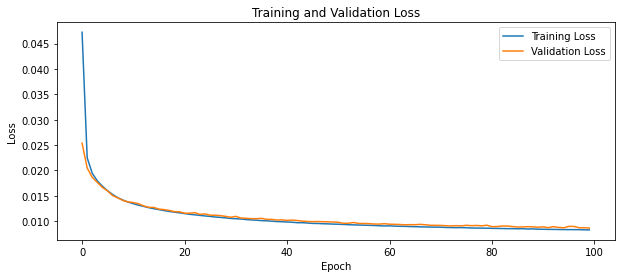

In [8]:
history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test), verbose=False)
plot_history(history.history)

We are however still limited by the simple nature of the model - i.e. just dense layers, which limits what we can get in terms of model complexity.

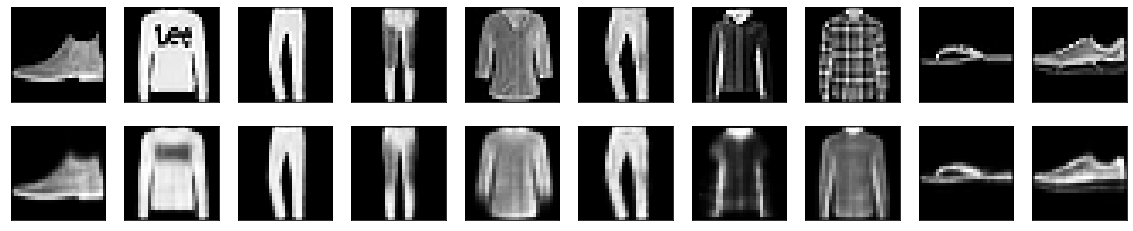

In [9]:
decoded_imgs = autoencoder.predict(x_test)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can also grab our compressed representation and pass it though t-SNE to get an idea of what's being learnt. 

What we see is broad similarities in shape between the two plots, though (to my eyes) we're getting slightly better separation for the embedding than the original. It should be noted, that not getting perfect separation (or even good separation) in our embedding space is not a shock. We're not using any class information (this is an unsupervised process), so we don't expect to get fantastic separation here, though we do see that we change the distributions somewhat through the compression. The fact that we're getting slightly improved separation does indicate that we're learning something about relationships in the data. Again, this is not entirely different to what we'd see with PCA.

Text(0.5, 1.0, 'Compressed Data')

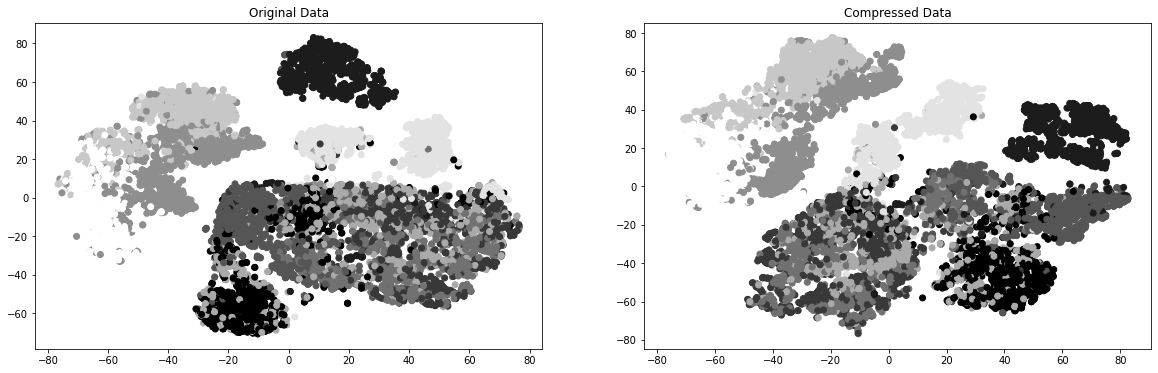

In [10]:
bottleneck_output = autoencoder.get_layer('bottleneck').output 
bottleneck_model = Model(inputs = autoencoder.input, outputs = bottleneck_output)
bottleneck_prediction = bottleneck_model.predict(x_test)

fig = plt.figure(figsize=[20, 6])

tsne_embeddings_original = TSNE(random_state=4).fit_transform(x_test)
ax = fig.add_subplot(1, 2, 1)
ax.scatter(tsne_embeddings_original[:,0], tsne_embeddings_original[:,1], c = y_test.flatten());
ax.set_title('Original Data')

tsne_embeddings = TSNE(random_state=4).fit_transform(numpy.reshape(bottleneck_prediction, (-1, encoding_dim)))
ax = fig.add_subplot(1, 2, 2)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());
ax.set_title('Compressed Data')

## A Better Network
Let's add some convolutions.

Note the structure of our CNN here and the filter numbers, they're backwards to what we're used to.

Our first Conv2D layer has 16 filters, then we have 8 and then 4. Remember that we're aiming for a compressed representation in the middle (also referred to as a bottleneck), so we want to have fewer parameters in the middle here, which means a smaller number of filters.

Our decoder is then essentially a reverse of the encoder. Note that our final layer is a 1x1 2D Convolution. Rememebr that this is learning a weighted combination of filter channels, so essentially we're going from 16 channels down to the 1 output channel that we want.

In [11]:
(x_train, _), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = numpy.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = numpy.reshape(x_test, (len(x_test), 28, 28, 1))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
bottleneck (MaxPooling2D)    (None, 4, 4, 4)           0   

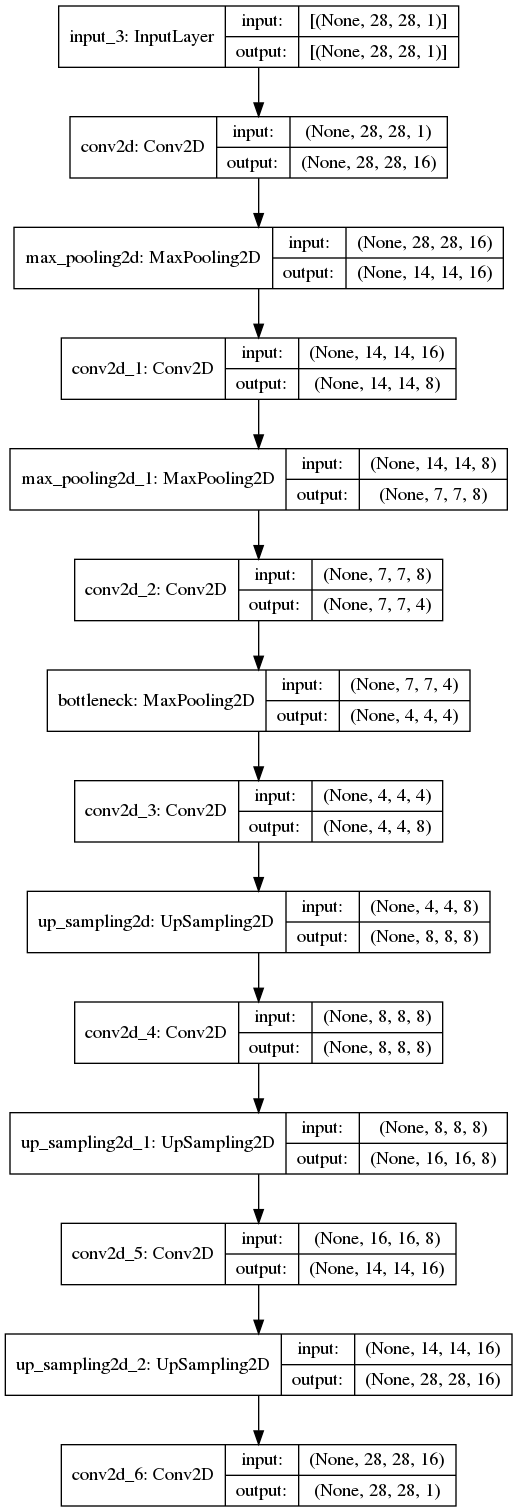

In [12]:
input_img = Input(shape=(28, 28, 1))

# encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)

# compressed representation
encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)
# at this point the representation is (4, 4, 4) i.e. 64-dimensional

# decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
print(autoencoder.summary())
plot_model(autoencoder, show_shapes=True)

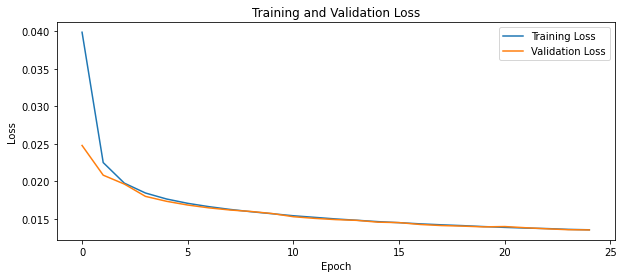

In [13]:
history = autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test), verbose=False)
plot_history(history.history)

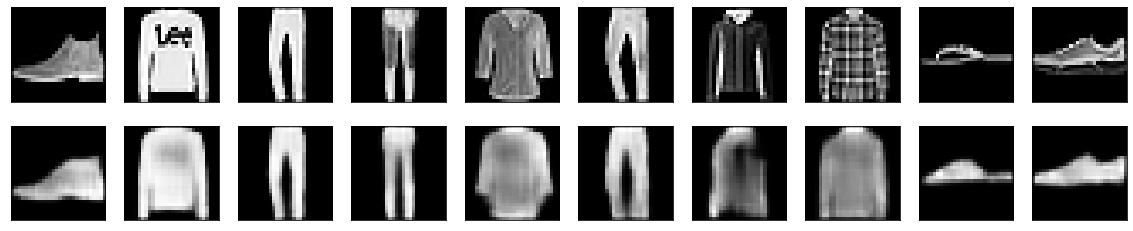

In [14]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Looking at our reconstructed outputs, they're not really better than what we had for our earlier dense network. Though it's worth noting the difference in model size. Our early network had around ~500,000 parameters. This one has a bit under 4,000. 

We can also visualise the convolutional filter maps a little bit easier than the dense layer. Looking at these, we see strong similarities between embeddings of the same object class (for example, look at the convolution maps for all the shoes) which suggests that the network is learning something.

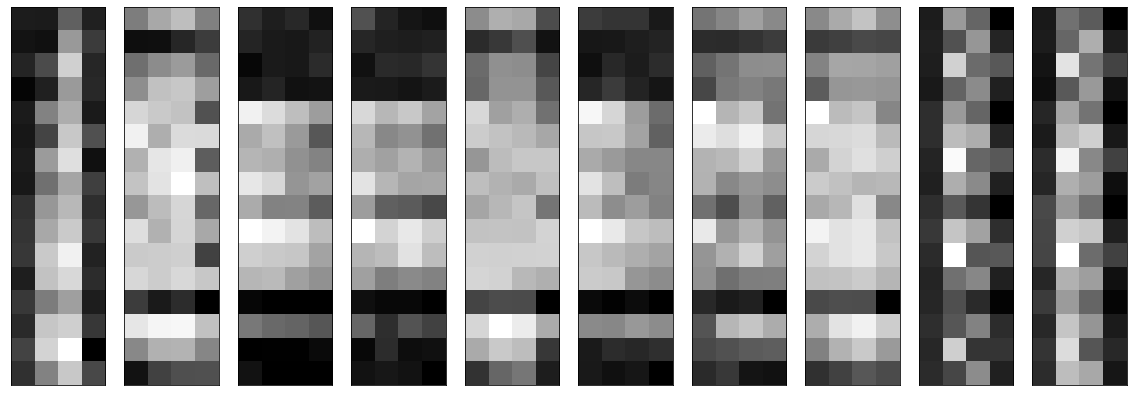

In [15]:
bottleneck_output = autoencoder.get_layer('bottleneck').output 
bottleneck_model = Model(inputs = autoencoder.input, outputs = bottleneck_output)
bottleneck_prediction = bottleneck_model.predict(x_test)
    
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(bottleneck_prediction[i].reshape(4, 4 * 4).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

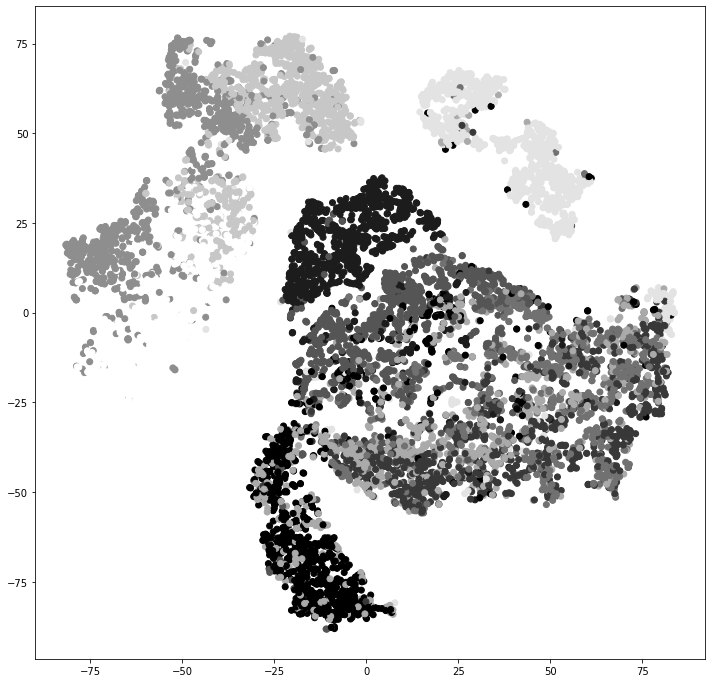

In [16]:
tsne_embeddings = TSNE(random_state=4).fit_transform(numpy.reshape(bottleneck_prediction, (-1, 64)))
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());

Looking at the embedding space, we've perhaps got slightly better separation between classes again.

### Adding Sparsity Again

Let's add sparsity back into the network in the bottleneck.

In [17]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(4, (3, 3), activation='relu', padding='same', activity_regularizer=regularizers.l1(10e-5))(x)
encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
print(autoencoder.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
bottleneck (MaxPooling2D)    (None, 4, 4, 4)           0   

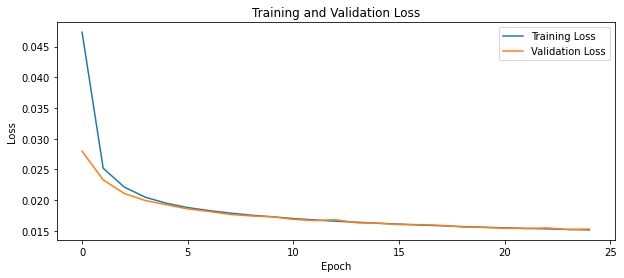

In [18]:
history = autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test), verbose=False)
plot_history(history.history)

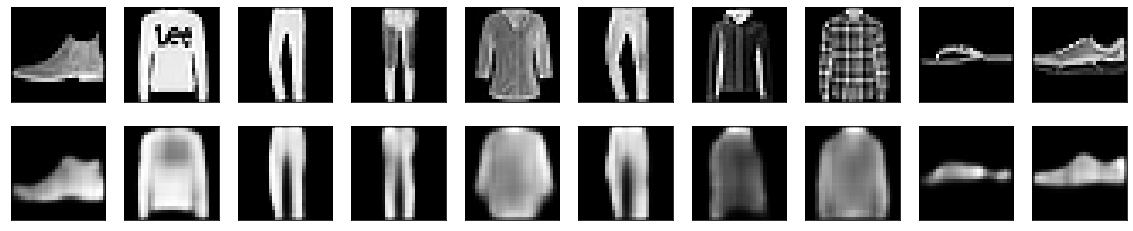

In [19]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

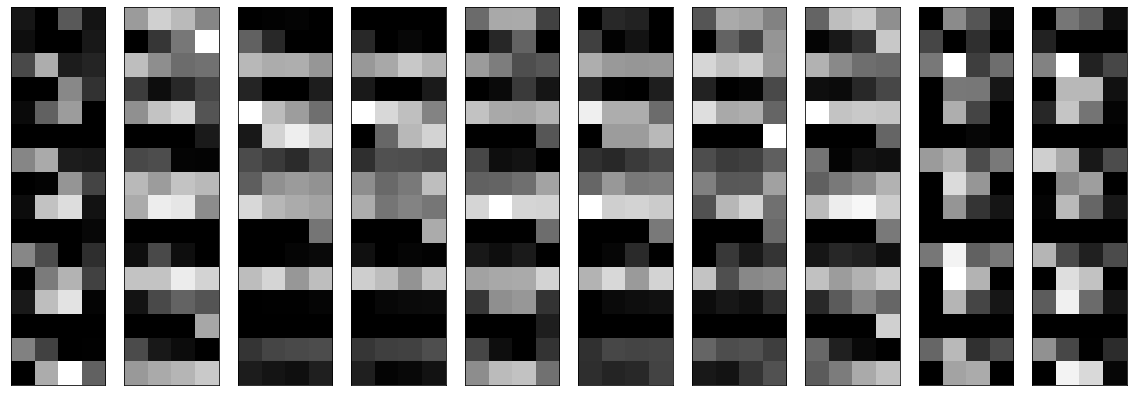

In [20]:
bottleneck_output = autoencoder.get_layer('bottleneck').output 
bottleneck_model = Model(inputs = autoencoder.input, outputs = bottleneck_output)
bottleneck_prediction = bottleneck_model.predict(x_test)
    
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(bottleneck_prediction[i].reshape(4, 4 * 4).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

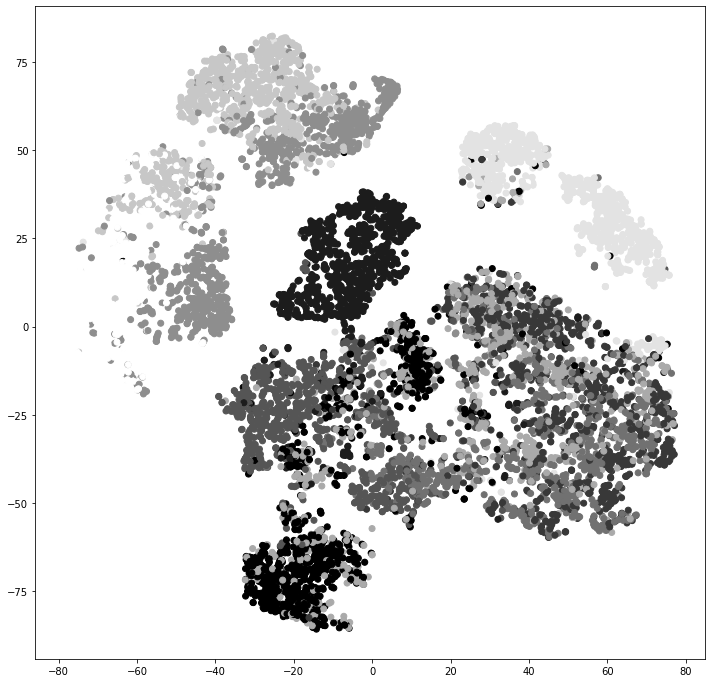

In [21]:
tsne_embeddings = TSNE(random_state=4).fit_transform(numpy.reshape(bottleneck_prediction, (-1, 64)))
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());

This doesn't greatly impact our reconstruction accuracy (if anything, we have less fine-grained detail now), though we do see a noted increase in how sparse our bottleneck features are (i.e. how many 0's we have).

We also have better separation in our embedding space.

### Adding More Convolutions

Let's add a few more filters either side of the bottleneck, and omit the last max-pool, making the representation a bit bigger.

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
bottleneck (Conv2D)          (None, 7, 7, 4)           580       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 16)          592 

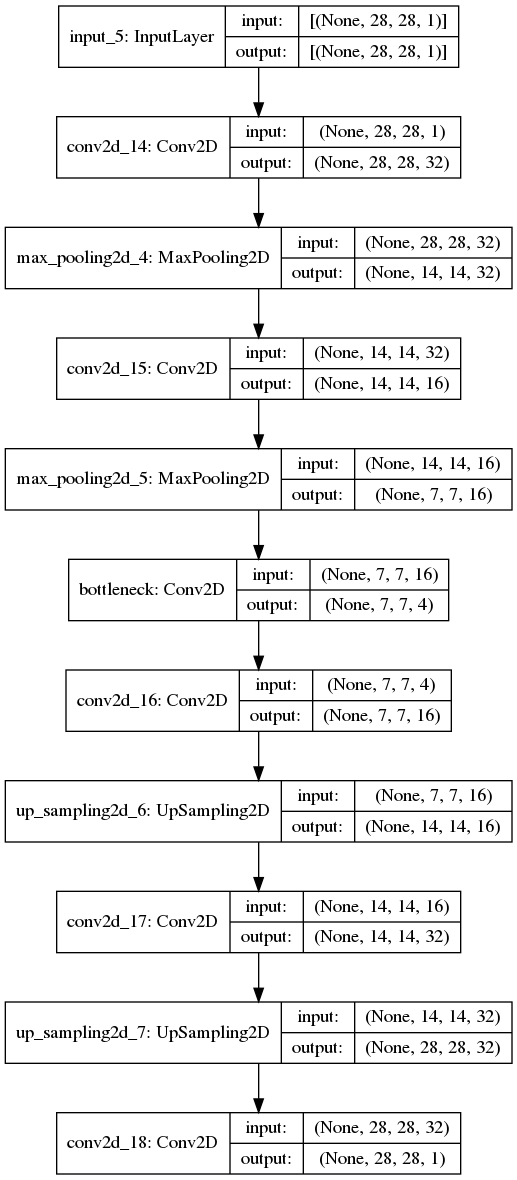

In [22]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(4, (3, 3), activation=None, padding='same', activity_regularizer=regularizers.l1(10e-5), name='bottleneck')(x)

# at this point the representation is (7, 7, 4)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
print(autoencoder.summary())
plot_model(autoencoder, show_shapes=True)

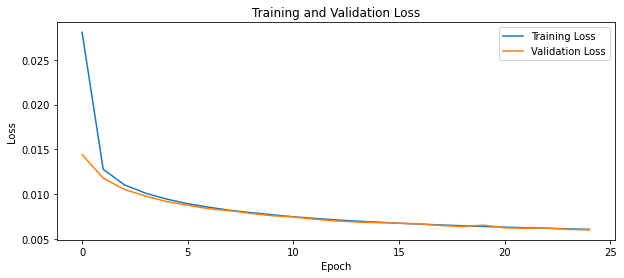

In [23]:
history = autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test), verbose=False)
plot_history(history.history)

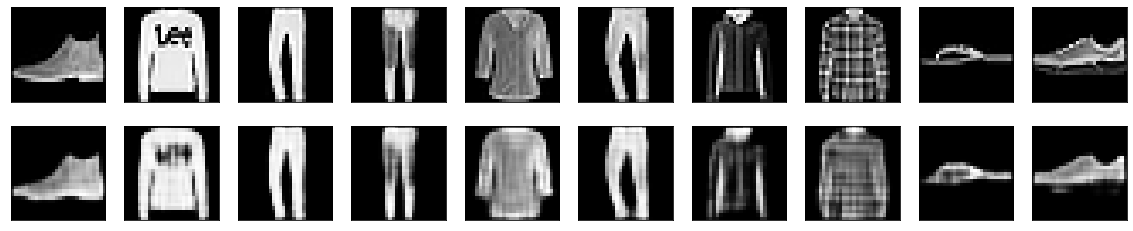

In [24]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

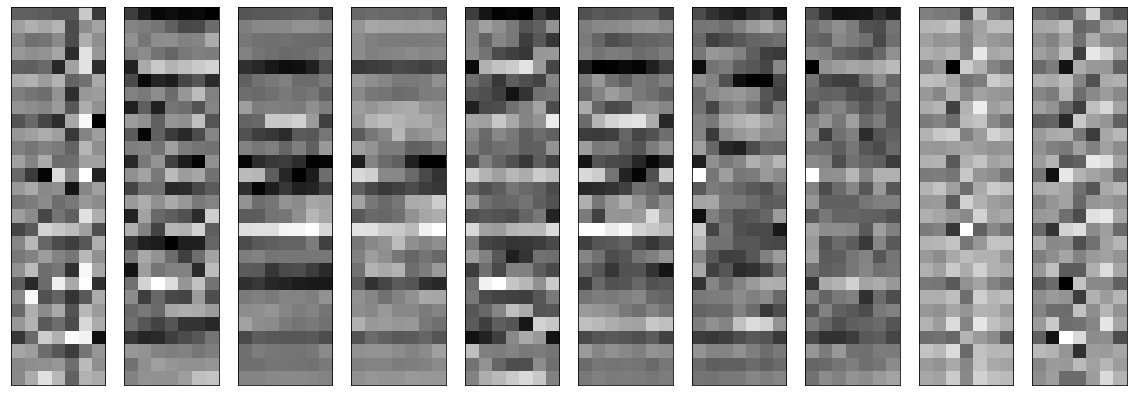

In [25]:
bottleneck_output = autoencoder.get_layer('bottleneck').output 
bottleneck_model = Model(inputs = autoencoder.input, outputs = bottleneck_output)
bottleneck_prediction = bottleneck_model.predict(x_test)
    
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(bottleneck_prediction[i].reshape(7, 7 * 4).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

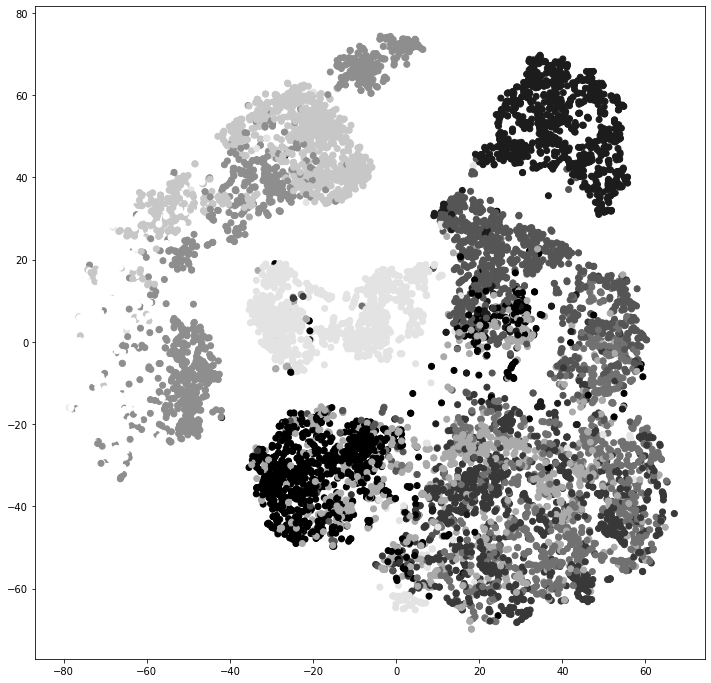

In [26]:
tsne_embeddings = TSNE(random_state=4).fit_transform(numpy.reshape(bottleneck_prediction, (-1, 7*7*4)))
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());

We can see this helps the network somewhat in terms of it's output quality, as we've now added more capacity to both encode and decode the representation. Removing the final max-pool also helps somewhat as it means we don't have the same loss of detail.

## Final Thoughts

In this example we've looked at auto-encoders. In a lot of respects, these seem like an odd network; the output is the same as the input - so what exactly is the point?

On their own, they don't make a heap of sense, but they have a lot of other uses and applications. These include:
* Learning a compressed representation. We've seen this a lot in this example, where we've explore via t-SNE what's in our bottleneck layer. This layer can be used as input to other processes.
* As a way to pre-train a network. Let's say we're looking at an image classification problem, but don't have much labelled data. One thing we could do is construct an auto-encoder and train this. The take the encoder only, add a classification layer, and fine-tune this sub-network. If we did this, we would **not** have the bottleneck we have here, as our aim is no longer compression.
  * This sort of approach could also be done in a single network, using multi-task learning.
* To detect abnormalities. If we train our network to reconstruct normal samples, and then present with an abnormal sample, it should struggle to reconstruct it correctly. We can use the reconstruction error as a measure to detect when a sample is abnormal.

The broad structure of an auto-encoder, having an encoder and decoder stage, is also extremely common across a large number of machine learning tasks.